### Spatial Control Demo

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from PIL import Image
import torch

from readout_guidance import rg_helpers
from script_spatial import set_edits_control

**Load the Stable Diffusion Pipeline and Readout Head**

The demo is pre-loaded to the SDXL pose readout head. Change the hyperparameters in the `config/spatial.yaml` file to try other control types. To try other base models, change `model_path` and `res`. To try other heads, change `aggregation_kwargs.aggregation_weights`. 

In [2]:
device = "cuda"
config_path = "configs/spatial.yaml"
config = OmegaConf.load(config_path)

In [3]:
# Load pipeline
pipeline, dtype = rg_helpers.load_pipeline(config, device)
batch_size = config["batch_size"]
latent_height = latent_width = pipeline.unet.config.sample_size
height = width = latent_height * pipeline.vae_scale_factor
image_dim = (width, height)
latent_dim = (latent_height, latent_width)

# Create edit config and load aggregation network
edits = rg_helpers.get_edits(config, device, dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Using output head with 3 channels


**Optional: Load Conditional Model**

If you would like to try Readout Guidance on top of a conditional model like T2IAdapter, uncomment the lines below.  Note that ControlNet is incompatible with the base SDXL config, since there are only weights available for SDv1-5. Make sure you also correctly switch out the base model when using ControlNet.

In [19]:
#Load ControlNet (SDv1-5) 
config["controlnet_path"] = "lllyasviel/control_v11p_sd15_openpose"
pipeline, dtype = rg_helpers.load_controlnet_pipeline(config, device)

# Load T2IAdapter (SDXL)
# config["adapter_path"] = "TencentARC/t2i-adapter-openpose-sdxl-1.0"
# pipeline, dtype = rg_helpers.load_adapter_pipeline(config, device)

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saqib\.cache\huggingface\hub\models--lllyasviel--control_v11p_sd15_openpose. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


**Load the Control Input**

To try other control inputs, change the `prompt` and `control_path`. To find examples of other inputs, look at the json files in `annotations/spatial`.

In [20]:
prompt = "a group of people playing with Frisbee's on the grass"
control_path = "data/spatial/pose/000000013291.png"

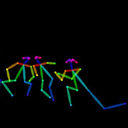

In [21]:
# Add control to edits
control_image = Image.open(control_path)
edits = set_edits_control(
    edits,
    control_image, 
    image_dim, 
    latent_dim,
    device
)
control_image.resize(latent_dim[::-1])

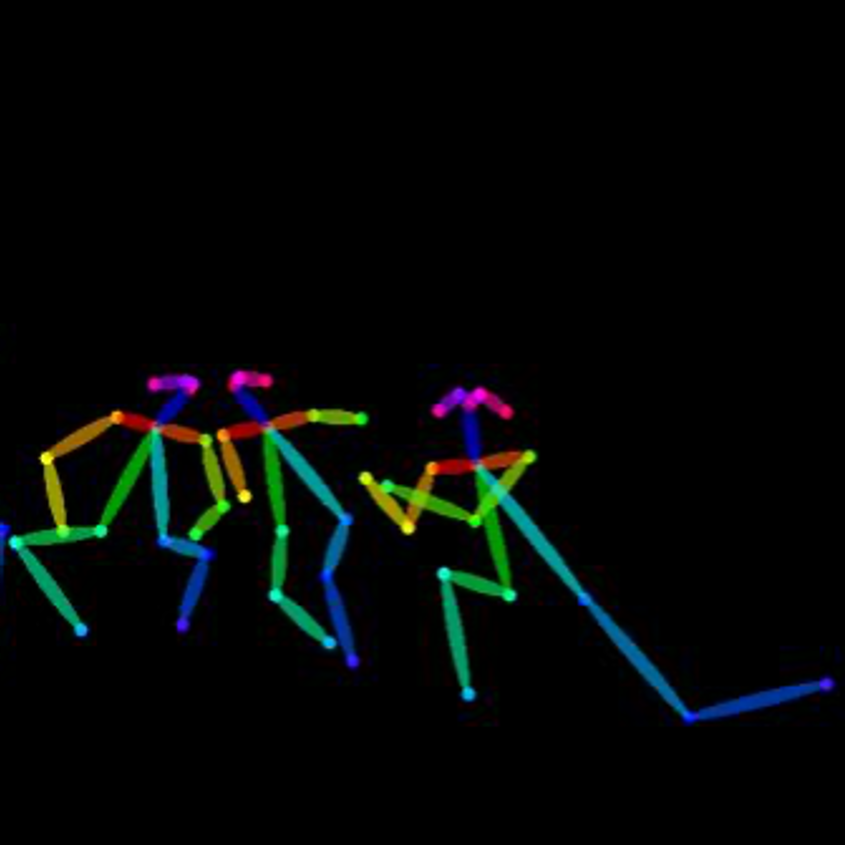

: 

In [ ]:
control_image

**Run Readout Guidance**

Run text-to-image generation. By default, the config `batch_size` is set to 2, where the left image is the result *without* readout guidance and the right image is the result *with* readout guidance. The cell will also log the readout guidance loss (if not applied, displayed as "N/A"), the predicted x0, and the predicted readouts.

In [6]:
generator = torch.Generator().manual_seed(config["seed"])
prompts, latents = rg_helpers.get_prompts_latents(
    pipeline,
    prompt,
    batch_size, 
    config["seed"],
    latent_dim,
    device,
    dtype,
)
print("prompts:",prompts)
print("latents:",latents.shape)

prompts: ["a group of people playing with Frisbee's on the grass", "a group of people playing with Frisbee's on the grass"]
latents: torch.Size([2, 4, 128, 128])


d:\3D Computer Vision\readout_guidance-main\readout_guidance\rg_helpers.py:120: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (pipeline.unet.in_channels, *latent_dim)


In [7]:
images, results = rg_helpers.run_preset_generation(
    pipeline, 
    prompts, 
    latents,
    edits,
    latent_dim=latent_dim,
    **config["generation_kwargs"]
)
print("pipeline:",pipeline)

Using model of type <class 'diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl.StableDiffusionXLPipeline'>
Using rg_ratio [0.0, 0.5]
Using num_optimizer_steps [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [8]:
orig_row = [
    control_image.resize(image_dim),
    Image.fromarray(images[0]).resize(image_dim),
    results[1].resize(image_dim)
]
rg_row = [
    control_image.resize(image_dim), 
    Image.fromarray(images[1]).resize(image_dim),
    results[2].resize(image_dim)
]

prompt_sep = "=" * 60
print(prompt_sep)
print(prompt)
print(prompt_sep)
print()
print("Without Readout Guidance:")
display(rg_helpers.view_images(orig_row))
print("With Readout Guidance:")
display(rg_helpers.view_images(rg_row))

NameError: name 'images' is not defined

In [9]:
import einops
import glob
import json
import numpy as np
from omegaconf import OmegaConf
import os
from PIL import Image
import sys
import torch
from tqdm import tqdm

In [10]:
from readout_guidance import rg_operators, rg_helpers

In [11]:
def image_to_array(source, source_range):
    source = np.array(source)
    source = einops.rearrange(source, 'w h c -> c w h')
    # Normalize source to [-1, 1]
    source = source.astype(np.float32) / 255.0
    source = rg_operators.renormalize(source, (0, 1), source_range)
    return source

def preprocess_control(source, resize_size, control_range):
    width, height = source.size
    crop_size = min(source.size)
    crop_x = np.random.randint(0, width - crop_size + 1)
    crop_y = np.random.randint(0, height - crop_size + 1)
    crop_resize_img = lambda img: img.convert("RGB").crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size)).resize(resize_size)
    source = crop_resize_img(source)
    return torch.from_numpy(image_to_array(source, control_range))

def set_edits_control(
    edits, 
    control_image, 
    image_dim, 
    latent_dim,
    device
):
    for edit in edits:
        if edit["head_type"] != "spatial":
            continue
        aggregation_config = edit["aggregation_kwargs"]
        control_range = aggregation_config["dataset_args"]["control_range"]
        sparse_loss = aggregation_config["dataset_args"]["sparse_loss"]
        control = preprocess_control(control_image, latent_dim, control_range)
        control = control.to(device)
        control_image = control_image.resize(image_dim)
        edit["control_image"] = control_image
        edit["control"] = control
        edit["control_range"] = control_range
        edit["sparse_loss"] = sparse_loss
    return edits

In [12]:
config = OmegaConf.load(config_path)
print("config:", config)

config: {'model_path': 'stabilityai/stable-diffusion-xl-base-1.0', 'control_type': 'pose', 'batch_size': 2, 'seed': 100, 'num_frames': 1, 'rg_kwargs': [{'head_type': 'spatial', 'loss_rescale': 0.5, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdxl_spatial_${control_type}.pt'}}], 'generation_kwargs': {'text_weight': 7.5, 'rg_weight': 0.02, 'rg_ratio': [0.0, 0.5], 'eta': 1.0, 'num_timesteps': 100, 'negative_prompt': 'poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off'}, 'output_dir': 'results/spatial/${control_type}', 'prompt_file': 'annotations/spatial/${control_type}.json', 'control_root': 'data/spatial/${control_type}'}


Load pipeline

In [13]:
pipeline, dtype = rg_helpers.load_pipeline(config, device)
print(pipeline)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [14]:
batch_size = config["batch_size"]
print("batch_size:", batch_size)
latent_height = latent_width = pipeline.unet.config.sample_size
print("latent height/width:", latent_height)
height = width = latent_height * pipeline.vae_scale_factor
print("height:", height)
image_dim = (width, height)
latent_dim = (latent_height, latent_width)
print("latent_dim:", latent_dim)

batch_size: 2
latent height/width: 128
height: 1024
latent_dim: (128, 128)


Initial Seeds

In [15]:
# Init seeds
num_frames = config["num_frames"]
root_seed = config["seed"]
frame_seeds = [root_seed + j for j in range(num_frames)]
np.random.seed(root_seed)

Create root save folder

In [16]:
save_folder = config["output_dir"]
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)
OmegaConf.save(config, f"{save_folder}/config.yaml")

Create edit config and load aggregation network

In [17]:
import matplotlib.pyplot as plt
import cv2

control paths: ['data/spatial/pose\\000000013291.png', 'data/spatial/pose\\000000354547.png']
{'000000013291': "A group of people playing with Frisbee's on the grass.", '000000354547': 'a man that is in a suit that is outside'}
Using output head with 3 channels
[{'head_type': 'spatial', 'loss_rescale': 0.5, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdxl_spatial_pose.pt', 'projection_dim': 384, 'model_id': 'stabilityai/stable-diffusion-xl-base-1.0', 'output_resolution': 128, 'load_resolution': 1024, 'diffusion_mode': 'generation', 'num_timesteps': 1000, 'prompt': '', 'negative_prompt': '', 'guidance_scale': -1, 'save_timestep': [0], 'weight_decay': 0, 'max_steps': 5000, 'val_every_n_steps': 1000, 'log_max': 10, 'lr': 0.001, 'dataset_args': {'size': 1024, 'control_root': 'control/openpose', 'control_range': [-0.5, 0.5], 'sparse_loss': True}, 'batch_size': 4, 'train_file': ['PascalVOC_train.json'], 'val_file': ['PascalVOC_val.json'], 'aggregation_kwargs': {'use_output_he

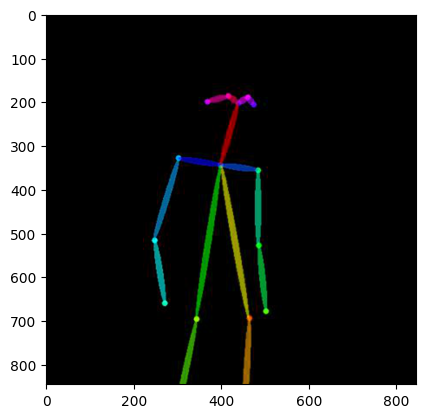

In [18]:
control_paths = glob.glob(f"{config['control_root']}/*")
print("control paths:", control_paths)
cntrl = cv2.imread(control_paths[1])
plt.imshow(cntrl)
name_prompt = json.load(open(config["prompt_file"]))
print(name_prompt)
edits = rg_helpers.get_edits(config, device, dtype)
print(edits)

  0%|          | 0/2 [00:00<?, ?it/s]d:\3D Computer Vision\readout_guidance-main\readout_guidance\rg_helpers.py:120: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (pipeline.unet.in_channels, *latent_dim)


pose image name: 000000013291
pose prompt name: A group of people playing with Frisbee's on the grass.
edits: [{'head_type': 'spatial', 'loss_rescale': 0.5, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdxl_spatial_pose.pt', 'projection_dim': 384, 'model_id': 'stabilityai/stable-diffusion-xl-base-1.0', 'output_resolution': 128, 'load_resolution': 1024, 'diffusion_mode': 'generation', 'num_timesteps': 1000, 'prompt': '', 'negative_prompt': '', 'guidance_scale': -1, 'save_timestep': [0], 'weight_decay': 0, 'max_steps': 5000, 'val_every_n_steps': 1000, 'log_max': 10, 'lr': 0.001, 'dataset_args': {'size': 1024, 'control_root': 'control/openpose', 'control_range': [-0.5, 0.5], 'sparse_loss': True}, 'batch_size': 4, 'train_file': ['PascalVOC_train.json'], 'val_file': ['PascalVOC_val.json'], 'aggregation_kwargs': {'use_output_head': True, 'output_head_channels': 3, 'bottleneck_sequential': False}, 'dims': [1280, 1280, 1280, 640, 640, 640, 320, 320, 320], 'id': 'kJiISOgmXc_gen-t

  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

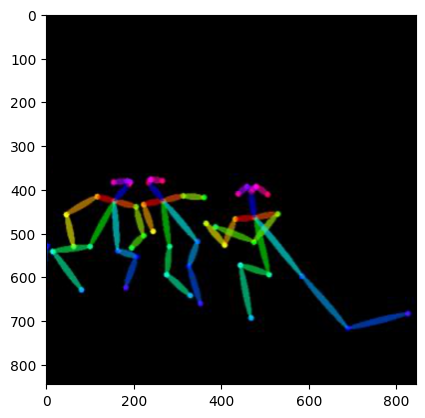

In [71]:
for control_path in tqdm(control_paths):
    # create name save folder 
    name = os.path.basename(control_path).split('.')[0]
    print("pose image name:", name)
    prompt = name_prompt[name]
    print("pose prompt name:", prompt)
    save_folder = f"{config['output_dir']}/{name}"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    ### create edits 
    control_image = Image.open(control_path)
    plt.imshow(control_image)
    control_image.save(f"{save_folder}/control.png")
    edits = set_edits_control(edits, control_image, image_dim, latent_dim, device)
    print("edits:", edits)
    for j in range(num_frames):
        prompts, latents = rg_helpers.get_prompts_latents(pipeline, prompt, batch_size, frame_seeds[j], latent_dim, device, dtype)
        print("prompts:", prompts)
        print("latents:", latents)
        print(f"latent_dim: {latent_dim}")
        images, results = rg_helpers.run_preset_generation(pipeline, prompts, latents, edits, latent_dim=latent_dim,**config["generation_kwargs"])

        
    


